In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

In [3]:
# binaries from here:
# http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/142/160/v3

# double x-matched to Gaia DR2 & B-J Distances

In [4]:
file = '1540938945496A.csv'
df = pd.read_csv(file)

df.columns

Index(['angDist', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest', 'B_rest',
       'rlen', 'ResFlag', 'ModFlag', 'angDist.1', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE'],
      dtype='object')

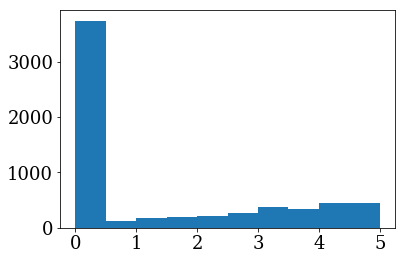

In [5]:
_ = plt.hist(df['angDist'])

In [10]:
# ok = ((df['angDist'] < 0.3) & (df['parallax_error'] / df['parallax'] < 0.05) & 
#       (df['phot_g_mean_flux_error'] / df['phot_g_mean_flux'] < 0.01))

ok = np.where(np.isfinite(df['parallax']) & # this is basically the same as the TGAS file...
              (df['parallax_error'] < 0.1) &
              (df['ModFlag'] == 1) & 
              (df['ResFlag'] == 1) &
              np.isfinite(df['bp_rp']) & 
              (df['phot_bp_mean_flux_error']/df['phot_bp_mean_flux'] < 0.02) & 
              (df['phot_rp_mean_flux_error']/df['phot_rp_mean_flux'] < 0.02) & 
              (df['phot_g_mean_flux_error']/df['phot_g_mean_flux'] < 0.02) & 
              (df['angDist'] < 0.5))[0]
ok.shape # this is most of the true EBs

(2408,)

Text(0.5,1,'Kepler EBs')

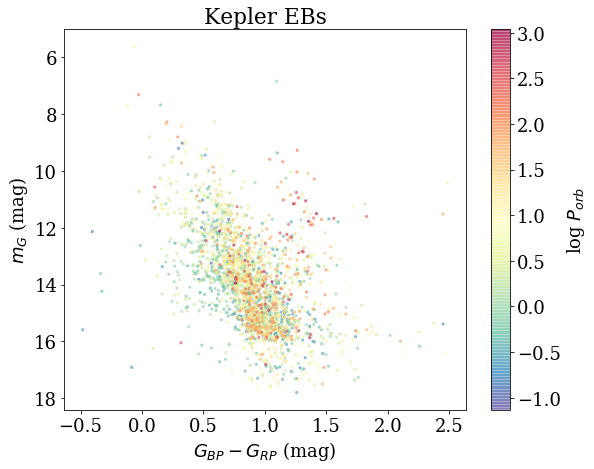

In [42]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok], 
            c=np.log10(df['Per'][ok]), cmap=cmap, s=5, alpha=0.5)
plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
plt.ylabel('$m_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler EBs')

In [29]:
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = 'MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

# mist_ms1 = np.where((mist['phase']==0) & 
#                     (mist['log10_isochrone_age_yr'] == 9.) & 
#                     (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]

mist_ms1 = np.where((mist['phase'] < 3) & (mist['log10_isochrone_age_yr'] == 8.5))[0][::-1]
mist_ms2 = np.where((mist['phase'] < 3) & (mist['log10_isochrone_age_yr'] == 9.5))[0][::-1]

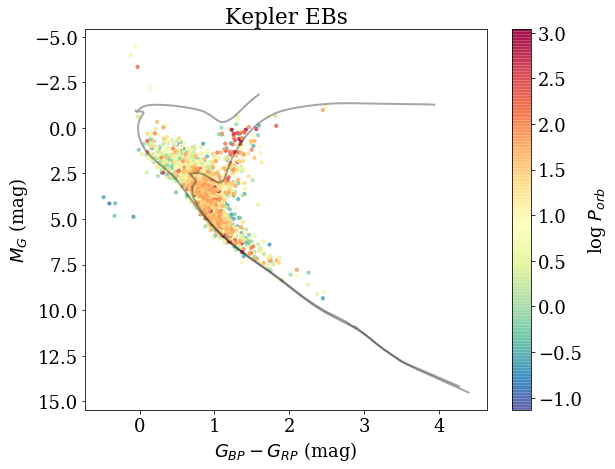

In [45]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.35)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
         mist['Gaia_G_DR2Rev'].values[mist_ms2], c='k', lw=2, alpha=0.35)


plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
cb.set_clim(-1.2,3)
plt.ylabel('$M_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler EBs')

# plt.xlim(-1,3)
# plt.ylim(10,-5)
plt.savefig('Kepler_EBs'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [32]:
# another catalog to look at is Catalina:
# http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJS/213/9/table3

In [33]:
file = '1540942562357A.csv'
df2 = pd.read_csv(file)

df2.columns

Index(['angDist', 'ra_epoch2000', 'dec_epoch2000', 'errHalfMaj', 'errHalfMin',
       'errPosAng', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'duplicated_source', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest', 'B_rest',
       'rlen', 'ResFlag', 'ModFlag', '_RAJ2000', '_DEJ2000', 'CRTS', 'RAJ2000',
       'DEJ2000', '<Vmag>', 'Per', 'Vamp', 'Cl', 'f_Cl', 'Simbad'],
      dtype='object')

In [61]:
ok2 = np.where(np.isfinite(df2['parallax']) & # this is basically the same as the TGAS file...
              (df2['parallax_error']/df2['parallax'] < 0.1) &
              (df2['ModFlag'] == 1) & 
              (df2['ResFlag'] == 1) &
              np.isfinite(df2['bp_rp']) & 
              (df2['phot_bp_mean_flux_error']/df2['phot_bp_mean_flux'] < 0.02) & 
              (df2['phot_rp_mean_flux_error']/df2['phot_rp_mean_flux'] < 0.02) & 
              (df2['phot_g_mean_flux_error']/df2['phot_g_mean_flux'] < 0.02) & 
              (df2['angDist'] < 0.5) &
              np.isfinite(df2['Per']))[0]
ok2.shape # this is most of the true EBs

(8863,)

Text(0.5,1,'Catalina EBs')

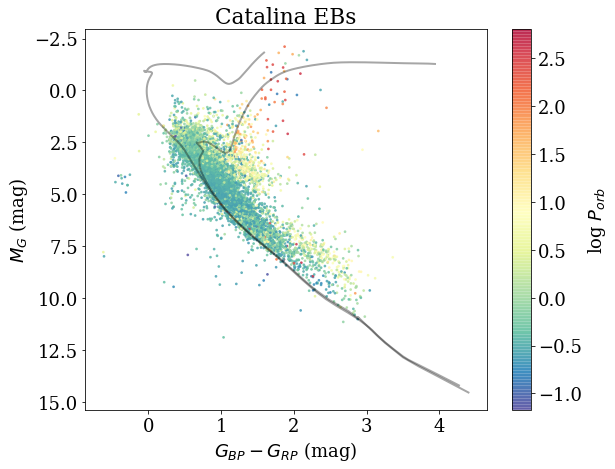

In [49]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df2['bp_rp'][ok2], df2['phot_g_mean_mag'][ok2] - 5. * np.log10(df2['rest'].values[ok2]) + 5, 
            c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.35)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
         mist['Gaia_G_DR2Rev'].values[mist_ms2], c='k', lw=2, alpha=0.35)


plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
cb.set_clim(-1.2,3)

plt.ylabel('$M_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Catalina EBs')

# plt.xlim(-1,3)
# plt.ylim(10,-5)
# plt.savefig('Kepler_EBs'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

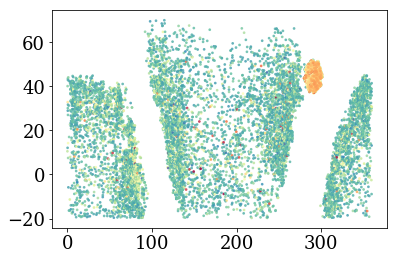

In [57]:
plt.scatter(df2['ra'][ok2], df2['dec'][ok2], c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

plt.scatter(df['ra'][ok], df['dec'][ok], c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=3)

(11, -2)

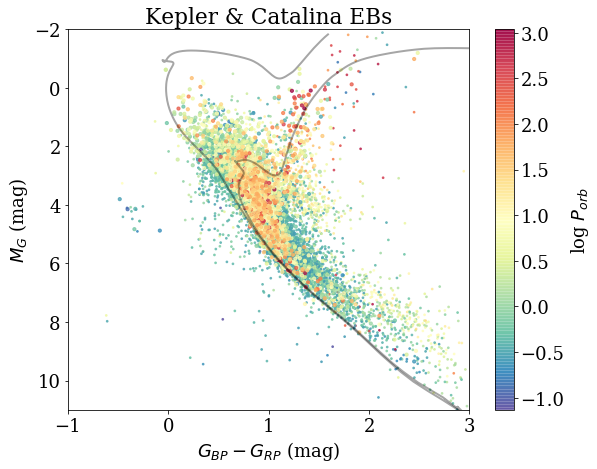

In [62]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df2['bp_rp'][ok2], df2['phot_g_mean_mag'][ok2] - 5. * np.log10(df2['rest'].values[ok2]) + 5, 
            c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)


plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.35)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
         mist['Gaia_G_DR2Rev'].values[mist_ms2], c='k', lw=2, alpha=0.35)


plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
# cb.set_clim(-1.2,3)

plt.ylabel('$M_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler & Catalina EBs')

plt.xlim(-1,3)
plt.ylim(11,-2)
# plt.savefig('Kepler_EBs'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

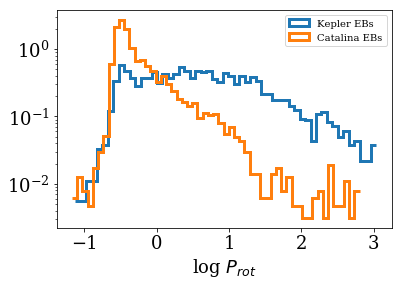

In [72]:
_ = plt.hist(np.log10(df['Per'][ok]), normed=True, histtype='step', lw=3, bins=55, label='Kepler EBs')
_ = plt.hist(np.log10(df2['Per'][ok2]), normed=True, histtype='step', lw=3, bins=55, label='Catalina EBs')

plt.xlabel('log $P_{rot}$')
plt.yscale('log')
plt.legend(fontsize=10)